In [103]:
#Configuracion de entorno
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
from src.config import Paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

paths = Paths()

#### Objetivo general: transformar datos transaccionales limpios en una tabla a nivel cliente, lista para segmentación y modelado.

In [104]:
# Cargamos los datos limpios del noteboook anterior 
data = pd.read_parquet(paths.data_noOutlierData)
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price,Outlier Flag
0,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,0
1,489435,22353,LUNCHBOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,0
2,489436,21754,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,17.85,0
3,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.69,13078.0,United Kingdom,27.04,0
4,489436,22119,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.95,13078.0,United Kingdom,20.85,0


In [105]:
# Definimos fecha de referencia
maxDate = pd.to_datetime(max(data['InvoiceDate']))
refDate = maxDate + pd.Timedelta(days=1)

print(f'La observacion mas reciente es de {maxDate} por lo tanto, la fecha de referencia es {refDate}')

La observacion mas reciente es de 2011-12-09 12:50:00 por lo tanto, la fecha de referencia es 2011-12-10 12:50:00


In [106]:
RFM = (
    data.groupby('Customer ID')
        .agg(
            Recency = ('InvoiceDate', lambda x: (refDate - x.max()).days),
            Frequency = ('Invoice', 'nunique'),
            Monetary =  ('Total Price', 'sum')
        )
        .reset_index()
)
RFM.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,529,10,327.86
1,12347.0,2,8,3551.26
2,12348.0,249,2,118.20
3,12349.0,19,3,2437.44
4,12350.0,310,1,274.00


In [107]:
RFM.describe()

,Recency,Frequency,Monetary
count,5617.000000,5617.000000,5.617000e+03
mean,201.453267,6.256899,1.606685e+03
std,208.273221,40.546187,2.233159e+04
min,1.000000,1.000000,1.900000e+00
25%,26.000000,1.000000,2.251400e+02
50%,97.000000,3.000000,5.619100e+02
75%,379.000000,6.000000,1.389240e+03
max,739.000000,2926.000000,1.659001e+06


In [108]:

recencyCheck = (RFM['Recency'] >= 0).all()
frequencyCheck = (RFM['Frequency'] > 0).all()
monetaryCheck = (RFM['Monetary'] >= 0).all()

if recencyCheck and frequencyCheck and monetaryCheck:
    print('RFM esta ok \n'
        f'Recency {recencyCheck} \n'
        f'Frequency {frequencyCheck} \n'
        f'Monetary {monetaryCheck}')
else:
    print('Tenemos problemas con RFM \n'
        f'Recency {recencyCheck} \n'
        f'Frequency {frequencyCheck} \n'
        f'Monetary {monetaryCheck}')

RFM esta ok 
Recency True 
Frequency True 
Monetary True


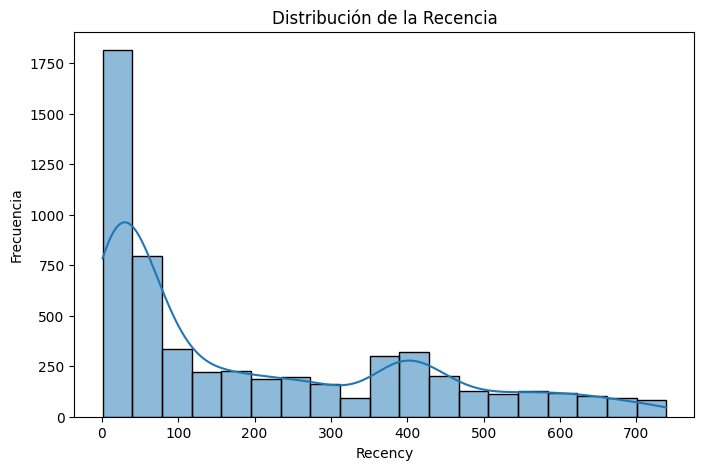

In [109]:
plt.figure(figsize=(8, 5))
sns.histplot(RFM['Recency'], kde=True)
plt.xlabel('Recency')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Recencia')
plt.show()

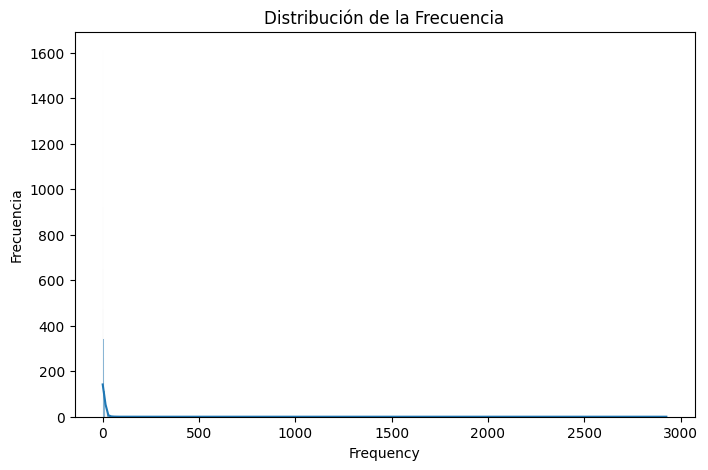

In [110]:
plt.figure(figsize=(8, 5))
sns.histplot(RFM['Frequency'], kde=True)
plt.xlabel('Frequency')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Frecuencia')
plt.show()

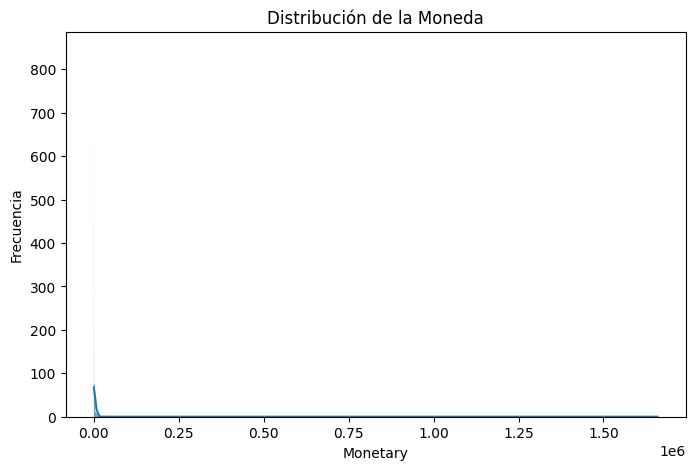

In [111]:
plt.figure(figsize=(8, 5))
sns.histplot(RFM['Monetary'], kde=True)
plt.xlabel('Monetary')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Moneda')
plt.show()

In [ ]:
transformedRFM = RFM.copy()

transformedRFM['logFrequency'] = np.log1p(transformedRFM['Frequency'])
transformedRFM['logMonetary'] = np.log1p(transformedRFM['Monetary'])
transformedRFM

,Customer ID,Recency,Frequency,Monetary,logFrequency,logMonetary
0,12346.0,529,10,327.86,2.397895,5.795632
1,12347.0,2,8,3551.26,2.197225,8.175339
2,12348.0,249,2,118.20,1.098612,4.780803
3,12349.0,19,3,2437.44,1.386294,7.799114
4,12350.0,310,1,274.00,0.693147,5.616771
...,...,...,...,...,...,...
5612,18284.0,432,1,245.90,0.693147,5.508983
5613,18285.0,661,1,173.00,0.693147,5.159055
5614,18286.0,477,2,994.94,1.098612,6.903687
5615,18287.0,59,6,1703.29,1.945910,7.440904


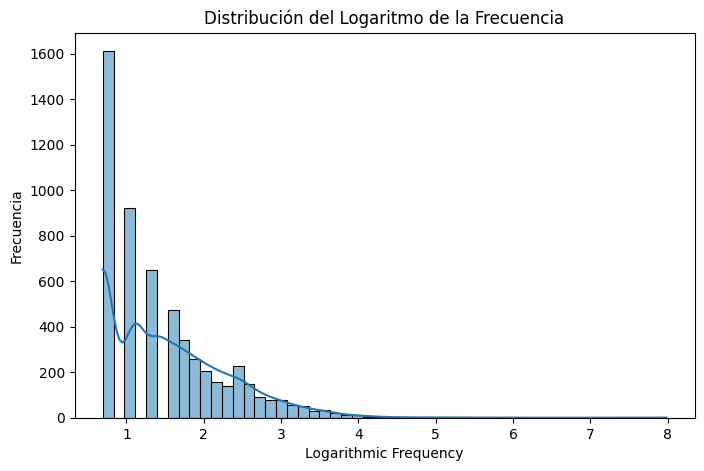

In [113]:
plt.figure(figsize=(8, 5))
sns.histplot(transformedRFM['logFrequency'], kde=True)
plt.xlabel('Logarithmic Frequency')
plt.ylabel('Frecuencia')
plt.title('Distribución del Logaritmo de la Frecuencia')
plt.show()

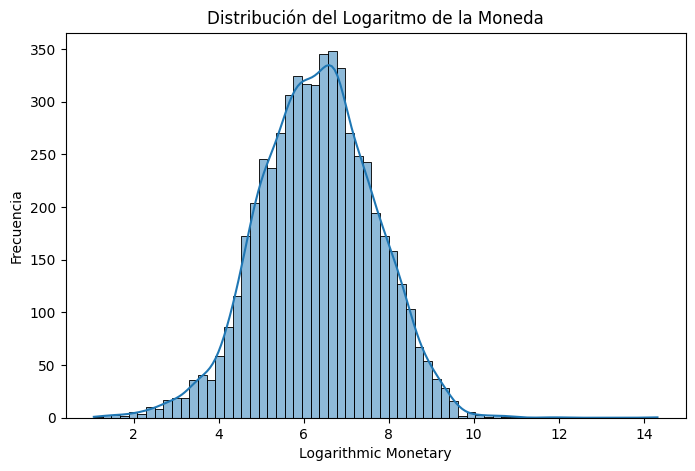

In [114]:
plt.figure(figsize=(8, 5))
sns.histplot(transformedRFM['logMonetary'], kde=True)
plt.xlabel('Logarithmic Monetary')
plt.ylabel('Frecuencia')
plt.title('Distribución del Logaritmo de la Moneda')
plt.show()

In [115]:
transformedRFM

,Customer ID,Recency,Frequency,Monetary,logFrequency,logMonetary
0,12346.0,529,10,327.86,2.397895,5.795632
1,12347.0,2,8,3551.26,2.197225,8.175339
2,12348.0,249,2,118.20,1.098612,4.780803
3,12349.0,19,3,2437.44,1.386294,7.799114
4,12350.0,310,1,274.00,0.693147,5.616771
...,...,...,...,...,...,...
5612,18284.0,432,1,245.90,0.693147,5.508983
5613,18285.0,661,1,173.00,0.693147,5.159055
5614,18286.0,477,2,994.94,1.098612,6.903687
5615,18287.0,59,6,1703.29,1.945910,7.440904


In [137]:
scaler = StandardScaler()

rescaledRFM = transformedRFM.copy()

rescaledRFM['rescaledRecency'] = scaler.fit_transform(rescaledRFM[['Recency']])
rescaledRFM['rescaledLogMonetary'] = scaler.fit_transform(rescaledRFM[['logMonetary']])
rescaledRFM['rescaledLogFrequency'] = scaler.fit_transform(rescaledRFM[['logFrequency']])
rescaledRFM.describe()

,Recency,Frequency,Monetary,logFrequency,logMonetary,rescaledRecency,rescaledLogMonetary,rescaledLogFrequency
count,5617.000000,5617.000000,5.617000e+03,5617.000000,5617.000000,5.617000e+03,5.617000e+03,5.617000e+03
mean,201.453267,6.256899,1.606685e+03,1.512083,6.316070,6.830925e-17,-2.934768e-16,-4.933446e-17
std,208.273221,40.546187,2.233159e+04,0.784273,1.344289,1.000089e+00,1.000089e+00,1.000089e+00
min,1.000000,1.000000,1.900000e+00,0.693147,1.064711,-9.625391e-01,-3.906768e+00,-1.044290e+00
25%,26.000000,1.000000,2.251400e+02,0.693147,5.421154,-8.424937e-01,-6.657759e-01,-1.044290e+00
50%,97.000000,3.000000,5.619100e+02,1.386294,6.333120,-5.015650e-01,1.268415e-02,-1.604027e-01
75%,379.000000,6.000000,1.389240e+03,1.945910,7.237232,8.525462e-01,6.853015e-01,5.532080e-01
max,739.000000,2926.000000,1.659001e+06,7.981733,14.321727,2.581199e+00,5.955838e+00,8.249966e+00


#### ¿Por qué no es correcto usar RFM sin transformar?

Porque K-Means asume clusters esfericos que son altamente sensibles a outliers que estiran el cluster. 

Por otro lado, si las variables no tienen magnitudes similares una variable con grandes numero puede dominar todo el modelo.

#### ¿Por qué se escala después de transformar y no antes?

El log cambia la forma de la distribucion, reduce el sesgo y comprime valores extremos. Hace a la variable mas gaussiana

El escalado ajusta la magnitud y la varianza. No corrige el sesgo (esto lo hace el log). Solo escala las distancias pero mantiene distribucion.

#### ¿Que pasaria si no escalo antes de K-Means?

Los outliers dominarian el modelo. Los clusters no serian esfericos y podria caer en falacias. Los resultados no serian adecuados a la realidad guiandonos a decisiones de negocio equivocadas.

In [117]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price,Outlier Flag
0,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,0
1,489435,22353,LUNCHBOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,0
2,489436,21754,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,17.85,0
3,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.69,13078.0,United Kingdom,27.04,0
4,489436,22119,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.95,13078.0,United Kingdom,20.85,0


In [118]:
additionalFeatures = data.copy()
additionalFeatures = (
    additionalFeatures.groupby('Customer ID')
        .agg(
            ticketPromedio = ('Total Price', 'mean'),
            uniqueProducts = ('StockCode', 'nunique'),
            daysActive =  ('InvoiceDate', lambda x: (x.max() - x.min()).days),
            averageDaysOfBuys = ('InvoiceDate', lambda x: x.sort_values().diff().dt.days.mean())
        )
        .reset_index()
)

additionalFeatures.dropna(inplace=True)
additionalFeatures

,Customer ID,ticketPromedio,uniqueProducts,daysActive,averageDaysOfBuys
0,12346.0,10.245625,26,196,6.193548
1,12347.0,18.305464,104,402,2.067358
2,12348.0,13.133333,9,189,23.625000
3,12349.0,17.535540,116,570,4.130435
4,12350.0,18.266667,15,0,0.000000
...,...,...,...,...,...
5612,18284.0,14.464706,17,0,0.000000
5613,18285.0,17.300000,10,0,0.000000
5614,18286.0,16.863390,59,247,4.258621
5615,18287.0,17.742604,84,512,5.368421


In [119]:
mergedData = pd.DataFrame()
# mergedData = pd.merge(rescaledRFM, additionalFeatures, how='left', on='Customer ID')
mergedData

""


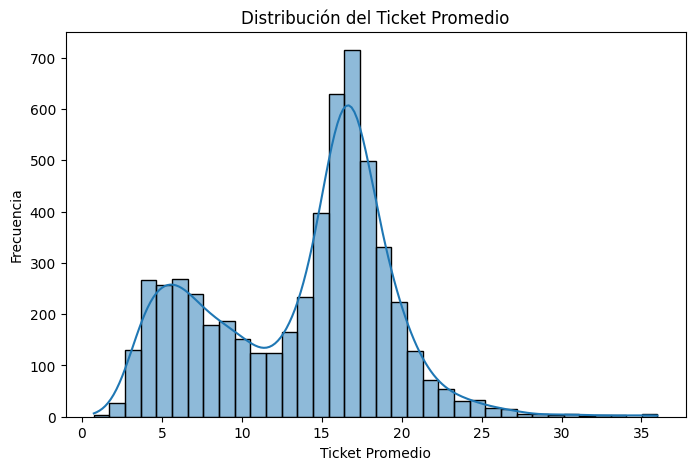

In [120]:
plt.figure(figsize=(8, 5))
sns.histplot(additionalFeatures['ticketPromedio'], kde=True)
plt.xlabel('Ticket Promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución del Ticket Promedio')
plt.show()

#### En este caso no deberiamos transformar porque perderiamos el comportamiento de los 2 posibles clusters visibles:

Hay un pico cerca de 5 que sugiere un cluster de pequenos compradores ocasionales y otro cerca de 18 que sugiere clientes con un ticket alto.

Aca lo recomendable es solo rescalar


# Skewness extrema se corrige.
# Bimodalidad se preserva

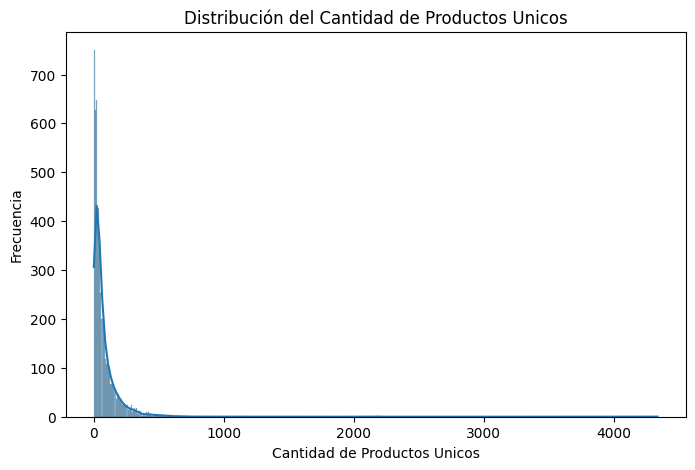

In [124]:
plt.figure(figsize=(8, 5))
sns.histplot(additionalFeatures['uniqueProducts'], kde=True)
plt.xlabel('Cantidad de Productos Unicos')
plt.ylabel('Frecuencia')
plt.title('Distribución del Cantidad de Productos Unicos')
plt.show()

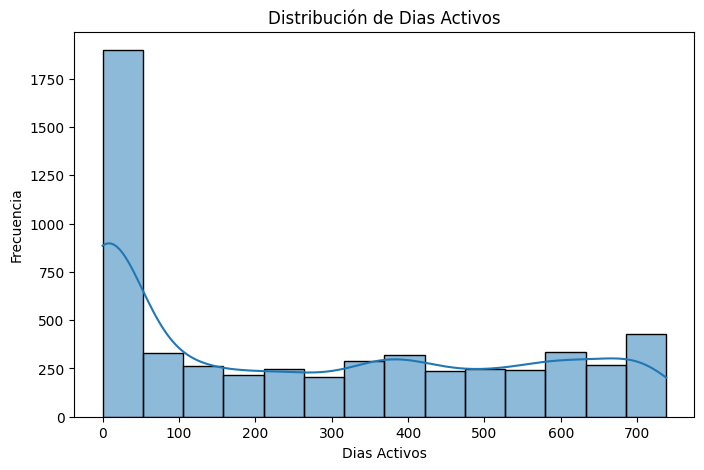

In [122]:
plt.figure(figsize=(8, 5))
sns.histplot(additionalFeatures['daysActive'], kde=True)
plt.xlabel('Dias Activos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dias Activos')
plt.show()

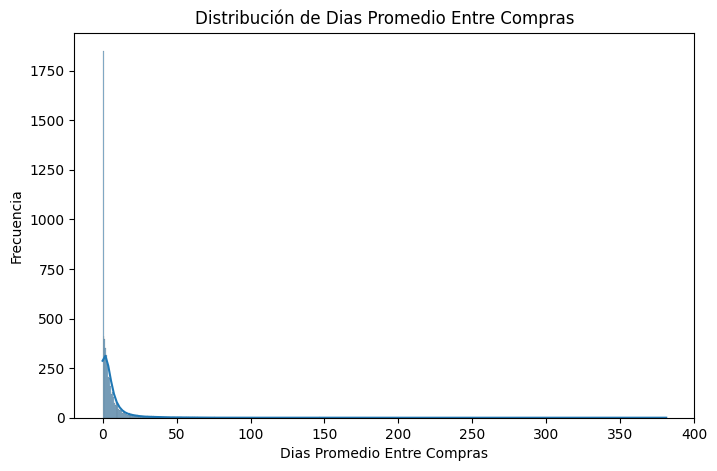

In [123]:
plt.figure(figsize=(8, 5))
sns.histplot(additionalFeatures['averageDaysOfBuys'], kde=True)
plt.xlabel('Dias Promedio Entre Compras')
plt.ylabel('Frecuencia')
plt.title('Distribución de Dias Promedio Entre Compras')
plt.show()

In [129]:
transformedFeatures = additionalFeatures.copy()
transformedFeatures['logUniqueProducts'] = np.log1p(transformedFeatures['uniqueProducts'])
transformedFeatures['logDaysActive'] = np.log1p(transformedFeatures['daysActive'])
transformedFeatures['logAverageDaysOfBuys'] = np.log1p(transformedFeatures['averageDaysOfBuys'])

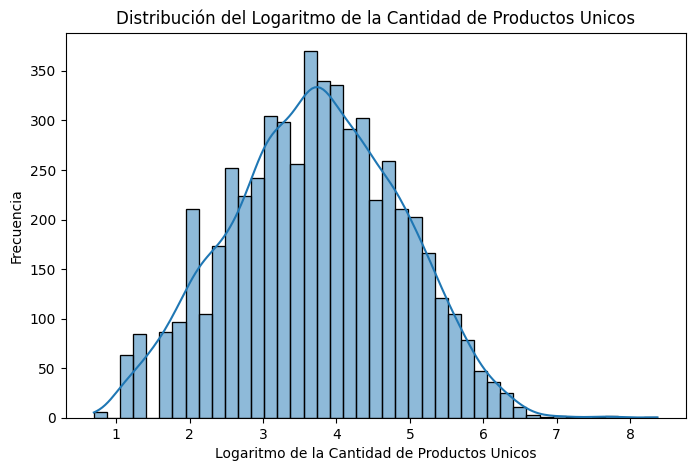

In [130]:
plt.figure(figsize=(8, 5))
sns.histplot(transformedFeatures['logUniqueProducts'], kde=True)
plt.xlabel('Logaritmo de la Cantidad de Productos Unicos')
plt.ylabel('Frecuencia')
plt.title('Distribución del Logaritmo de la Cantidad de Productos Unicos')
plt.show()

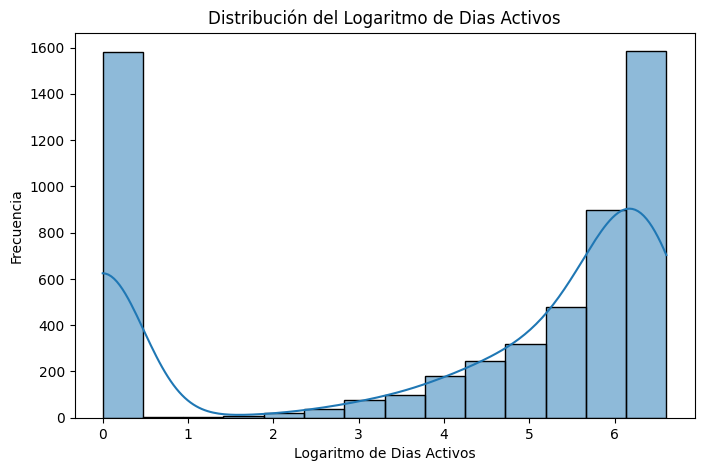

In [131]:
plt.figure(figsize=(8, 5))
sns.histplot(transformedFeatures['logDaysActive'], kde=True)
plt.xlabel('Logaritmo de Dias Activos')
plt.ylabel('Frecuencia')
plt.title('Distribución del Logaritmo de Dias Activos')
plt.show()

La variable Días Activos presenta una distribución bimodal extrema asociada a clientes de una sola compra y clientes recurrentes de largo plazo. Se decidió no aplicar transformación logarítmica para preservar esta estructura y permitir que el clustering capture estos comportamientos de manera explícita. Vamos a eliminar esta variable del dataset

In [135]:
transformedFeatures.drop('logDaysActive', axis=1, inplace=True)
transformedFeatures

,Customer ID,ticketPromedio,uniqueProducts,daysActive,averageDaysOfBuys,logUniqueProducts,logAverageDaysOfBuys
0,12346.0,10.245625,26,196,6.193548,3.295837,1.973185
1,12347.0,18.305464,104,402,2.067358,4.653960,1.120816
2,12348.0,13.133333,9,189,23.625000,2.302585,3.203762
3,12349.0,17.535540,116,570,4.130435,4.762174,1.635190
4,12350.0,18.266667,15,0,0.000000,2.772589,0.000000
...,...,...,...,...,...,...,...
5612,18284.0,14.464706,17,0,0.000000,2.890372,0.000000
5613,18285.0,17.300000,10,0,0.000000,2.397895,0.000000
5614,18286.0,16.863390,59,247,4.258621,4.094345,1.659869
5615,18287.0,17.742604,84,512,5.368421,4.442651,1.851352


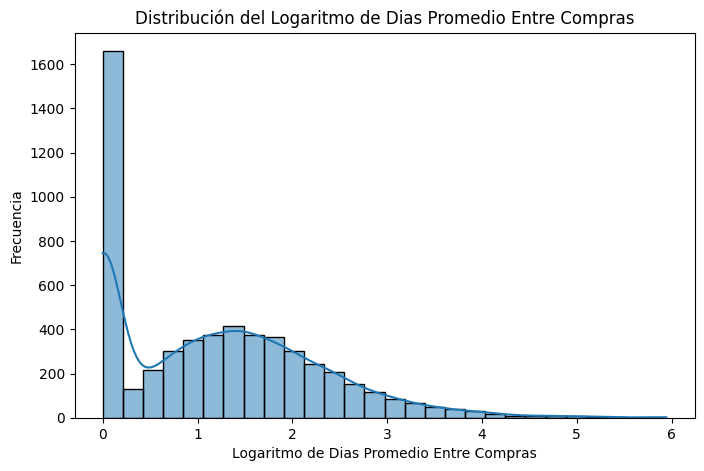

In [132]:
plt.figure(figsize=(8, 5))
sns.histplot(transformedFeatures['logAverageDaysOfBuys'], kde=True)
plt.xlabel('Logaritmo de Dias Promedio Entre Compras')
plt.ylabel('Frecuencia')
plt.title('Distribución del Logaritmo de Dias Promedio Entre Compras')
plt.show()

Aca mantenemos la transformacion y luego reescalar

En resumen:

    Ticket Promedio se rescala
    Dias activos se rescala
    Promedio de dias entre compras Log + escala
    Productos unicos Log + escala

In [144]:
rescaledFeatures = transformedFeatures.copy()
rescaledFeatures['rescaledTicketPromedio'] = scaler.fit_transform(rescaledFeatures[['ticketPromedio']])
rescaledFeatures['rescaledDaysActive'] = scaler.fit_transform(rescaledFeatures[['daysActive']])
rescaledFeatures['rescaledLogAverageDaysOfBuys'] = scaler.fit_transform(rescaledFeatures[['logAverageDaysOfBuys']])
rescaledFeatures['rescaledLogUniqueProducts'] = scaler.fit_transform(rescaledFeatures[['logUniqueProducts']])


toMergeFeatures = rescaledFeatures[['Customer ID','rescaledTicketPromedio', 'rescaledDaysActive',
       'rescaledLogAverageDaysOfBuys', 'rescaledLogUniqueProducts']]
toMergeFeatures

,Customer ID,rescaledTicketPromedio,rescaledDaysActive,rescaledLogAverageDaysOfBuys,rescaledLogUniqueProducts
0,12346.0,-0.613108,-0.297030,0.733206,-0.359486
1,12347.0,0.820827,0.506175,-0.062611,0.821543
2,12348.0,-0.099353,-0.324323,1.882140,-1.223221
3,12349.0,0.683849,1.161217,0.417636,0.915645
4,12350.0,0.813924,-1.061245,-1.109066,-0.814505
...,...,...,...,...,...
5612,18284.0,0.137513,-1.061245,-1.109066,-0.712080
5613,18285.0,0.641944,-1.061245,-1.109066,-1.140339
5614,18286.0,0.564266,-0.098178,0.440677,0.334899
5615,18287.0,0.720688,0.935072,0.619456,0.637787


In [146]:
toMergeRFM = rescaledRFM[['Customer ID','rescaledRecency','rescaledLogMonetary','rescaledLogFrequency']]
toMergeRFM

,Customer ID,rescaledRecency,rescaledLogMonetary,rescaledLogFrequency
0,12346.0,1.572818,-0.387182,1.129570
1,12347.0,-0.957737,1.383210,0.873679
2,12348.0,0.228311,-1.142168,-0.527249
3,12349.0,-0.876106,1.103316,-0.160403
4,12350.0,0.521221,-0.520246,-1.044290
...,...,...,...,...
5612,18284.0,1.107042,-0.600435,-1.044290
5613,18285.0,2.206657,-0.860765,-1.044290
5614,18286.0,1.323124,0.437160,-0.527249
5615,18287.0,-0.684034,0.836824,0.553208


In [148]:
mergedData = pd.merge(toMergeRFM, toMergeFeatures, how='left', on='Customer ID')
mergedData.head()

,Customer ID,rescaledRecency,rescaledLogMonetary,rescaledLogFrequency,rescaledTicketPromedio,rescaledDaysActive,rescaledLogAverageDaysOfBuys,rescaledLogUniqueProducts
0,12346.0,1.572818,-0.387182,1.129570,-0.613108,-0.297030,0.733206,-0.359486
1,12347.0,-0.957737,1.383210,0.873679,0.820827,0.506175,-0.062611,0.821543
2,12348.0,0.228311,-1.142168,-0.527249,-0.099353,-0.324323,1.882140,-1.223221
3,12349.0,-0.876106,1.103316,-0.160403,0.683849,1.161217,0.417636,0.915645
4,12350.0,0.521221,-0.520246,-1.044290,0.813924,-1.061245,-1.109066,-0.814505


In [149]:
mergedData.to_parquet(paths.data_processed / "Customer Clustering Features Data.parquet", index=False)